![](./resources/Custom_croptype_map.png)

### Content

- [Introduction](###-Introduction)
- [How to run this notebook?](###-How-to-run-this-notebook?)
- [Before you start](###-Before-you-start)
- [1. Gather and prepare your training data](###-1.-Gather-and-prepare-your-training-data)

ADD OTHER SECTIONS

### Introduction

This notebook guides you through the process of training a custom crop type classification model for your area, season and crop types of interest.

For training the model, you can use a combination of:
- publicly available in-situ reference data harmonized by the WorldCereal consortium;
- your own private reference data.

<div class="alert alert-block alert-warning">
In case you would like to use private reference data to train your model, make sure to first complete the workflow as outlined in our separate notebook <b>worldcereal_private_extractions.ipynb</b>.
</div>

After model training, we deploy your custom model to the cloud, from where it can be accessed by OpenEO, allowing you to apply your model on your area and season of interest and generate your custom crop type map.

### How to run this notebook?

#### Option 1: Run on Terrascope

You can use a preconfigured environment on [**Terrascope**](https://terrascope.be/en) to run the workflows in a Jupyter notebook environment. Just register as a new user on Terrascope or use one of the supported EGI eduGAIN login methods to get started.

Once you have a Terrascope account, you can run this notebook by clicking the button shown below.

<div class="alert alert-block alert-warning">When you click the button, you will be prompted with "Server Options". Make sure to select the "Worldcereal" image here. Did you choose "Terrascope" by accident? Then go to File > Hub Control Panel > Stop my server, and click the link below once again.</div>


<a href="https://notebooks.terrascope.be/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FWorldCereal%2Fworldcereal-classification&urlpath=lab%2Ftree%2Fworldcereal-classification%2Fnotebooks%2Fworldcereal_custom_croptype.ipynb&branch=main"><img src="https://img.shields.io/badge/Generate%20custom%20crop%20type%20map-Terrascope-brightgreen" alt="Generate custom crop type map" valign="middle"></a>


#### Option 2: Install Locally

If you prefer to install the package locally, you can create the WorldCereal environment using **Conda** or **pip**.

First clone the repository:
```bash
git clone https://github.com/WorldCereal/worldcereal-classification.git
cd worldcereal-classification
```
Next, install the package locally:
- for Conda: `conda env create -f environment.yml`
- for Pip: `pip install .[train,notebooks]`

### Before you start

In order to run WorldCereal crop mapping jobs from this notebook, you need to create an account on the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/).
This is free of charge and will grant you a number of free openEO processing credits to continue this demo.

### 1. Gather and prepare your training data

Note:
In case you would like to explore the availability of publicly available reference data for your region of interest, you can:

- use the WorldCereal Reference Data Module user interface, available [here](https://rdm.esa-worldcereal.org/). More explanation can be found [here](https://worldcereal.github.io/worldcereal-documentation/rdm/explore.html#explore-data-through-our-user-interface).
- use our dedicated notebook [worldcereal_RDM_demo.ipynb](https://github.com/WorldCereal/worldcereal-classification/blob/main/notebooks/worldcereal_RDM_demo.ipynb).

**Step 1: Select your area of interest**

Draw a bounding box specifying the region for which you want to generate a crop type map. 

<div class="alert alert-block alert-warning">
<b>Processing area:</b><br> 
The WorldCereal system is currently optimized to process <b>20 x 20 km</b> tiles.<br>
We recommend to not exceed this size too much, as this will result in considerable processing costs.

For testing purposes, we definitely recommend you to select a small area to start with.

A run of 250 km² will typically consume 40 credits and last around 20 mins.<br>
A run of 750 km² will typically consume 90 credits and last around 50 mins.<br>
A run of 2500 km² will typically consume 250 credits and last around 1h 40 mins.
</div>

When running the code snippet below, an interactive map will be visualized.
Click the Rectangle button on the left hand side of the map to start drawing your region of interest.
The widget will automatically store the coordinates of the last rectangle you drew on the map.

In [3]:
from worldcereal.utils.map import ui_map

map = ui_map(area_limit=2500)

**Step 2: Select your season of interest**

To gain an initial understanding of crop seasonality in your area of interest, you can consult the WorldCereal crop calendars (by executing the next cell), or check out the [USDA crop calendars](https://ipad.fas.usda.gov/ogamaps/cropcalendar.aspx).

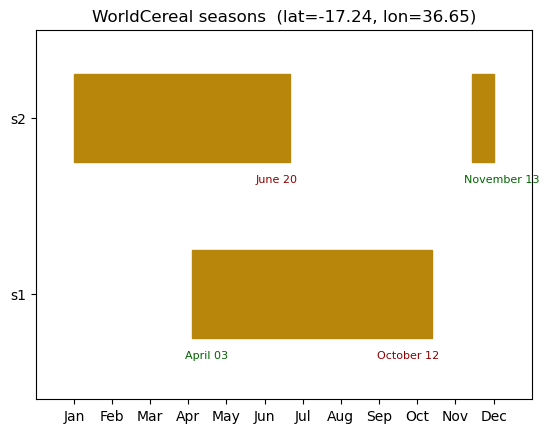

In [4]:
from notebook_utils.seasons import retrieve_worldcereal_seasons

spatial_extent = map.get_extent()
seasons = retrieve_worldcereal_seasons(spatial_extent)

Now use the slider to select your season of interest.<br>

Note that we always require you to specify a processing period of **12 months**.<br>
Just make sure your season of interest is nicely centered within the year you select.<br>
The `Season center` underneath the slider indicates the center of your selected period.

In [1]:
from notebook_utils.dateslider import date_slider

slider = date_slider()

**Step 3: Get all available reference data**

Now we query both public and private extractions and retrieve the relevant samples based on our defined area and season of interest.

By default, a spatial buffer of 250 km is applied to your area of interest to ensure sufficient training data is found.<br>
You can freely expand this search perimeter by changing the value of the `buffer` parameter.

As we are interested in training a custom crop type model, we explicitly apply a filter to only retain temporary crop samples.
Note that this implies mapping of permanent crops is currently not supported.

<div class="alert alert-block alert-warning">
<b>What to do in case no samples were found?</b><br> 

1. **Increase the buffer size**: Try increasing the buffer size by passing the `buffer` parameter to the `query_public_extractions` function (to a reasonable extent).
    *Current setting is: 250000 m².*
2. **Pick another area**
3. **Contribute data**: Collect some data and contribute to our global database! 🌍🌾 [Learn how to contribute here.](https://worldcereal.github.io/worldcereal-documentation/rdm/upload.html)

</div>

In [ ]:
from worldcereal.utils.refdata import query_public_extractions, query_private_extractions

# Retrieve the polygon you drew on the map
polygon = map.get_polygon_latlon()

# Specify a buffer distance to expand your search perimeter
buffer = 250000  # meters

# Query our public database of training data
public_data = query_public_extractions(polygon, buffer)

# Query your own private database of training data
private_data = query_private_extractions(polygon, buffer)

# Show what the data looks like
print('************')
print('Data Sample')
print(public_data.head())
print('************')
# Report on the contents of the data
print('************')
print('Data Summary')
print('************')
print(f"Found {public_data['sample_id'].nunique()} unique samples in the public data, spread across {public_data['ref_id'].nunique()} unique reference datasets.")
print(f'Public datasets: {sorted(list(public_data['ref_id'].unique()))}')
print('************')
print(f"Found {private_data['sample_id'].nunique()} unique samples in the private data, spread across {private_data['ref_id'].nunique()} unique reference datasets.")
print(f'Private datasets: {sorted(list(private_data['ref_id'].unique()))}')
print('************')

# Quick check on how many crop types are present in the data
public_crops = list(public_data['ewoc_code'].unique())
private_crops = list(private_data['ewoc_code'].unique())
all_crops = list(set(public_crops + private_crops))
print(f"Found {len(all_crops)} unique crop types in the extracted data.")

if len(all_crops) <= 1:
    raise ValueError("Not enough crop types found in the extracted data. Please try again with a larger buffer distance.")


**Step 4: Perform a quick quality check**

In this optional step, we provide you with some tools to quickly assess the quality of the datasets.

In [ ]:
# Check band statistics
from notebook_utils.extractions import get_band_statistics

dataset_name = ''

subset_public_data = public_data.loc[public_data['ref_id'] == dataset_name]
band_stats = get_band_statistics(subset_public_data)

In [ ]:
# Visualize timeseries for a few samples
from notebook_utils.extractions import visualize_timeseries

dataset_name = ''

subset_public_data = public_data.loc[public_data['ref_id'] == dataset_name]
band_stats = visualize_timeseries(subset_public_data)

Based on the reported contents or quality check of the datasets, you might want to drop some of the selected data before proceeding.<br>

Here is an example on how to drop a complete dataset from the extracted data:

In [ ]:
## Drop a specific dataset from public extractions
# dataset_name = '2021_AUT_LPIS_POLY_110'
# public_data = public_data.loc[public_data['ref_id'] != dataset_name]

**Step 5: Merge public and private data and filter based on timing of observation**

In this step, we merge the extracted data into one dataframe.

This dataframe is then converted into a format which can be used by our training feature computation and model training routines.

Lastly, we filter out any sample for which the observation date (attribute `valid_time`) does not match the selected season of interest.

In [ ]:
import pandas as pd
from worldcereal.utils.refdata import process_extractions_df

# Merge public and private data
merged_data = pd.merge(
    private_data,
    public_data,
    how="outer",
)
print(f'Total number of extracted samples: {merged_data.shape[0]}')

# Retrieve the date range you just selected
processing_period = slider.get_processing_period()

# Process the merged data
training_df = process_extractions_df(merged_data, processing_period)

# Report on the contents of the data
print('************')
print('Data Summary')
print('************')
print(f'Total number of samples remaining: {training_df.shape[0]}')
print(f'Samples originating from {training_df['ref_id'].nunique()} unique reference datasets.')
print('************')
print(f'Distribution of samples across years:')
print(training_df.year.value_counts())
print('************')
ncroptypes = training_df['ewoc_code'].nunique()
print(f'Number of crop types remaining: {ncroptypes}')
if ncroptypes <= 1:
    raise ValueError("Not enough crop types found in the extracted data. Please try again with a larger buffer distance.")

**Step 6: Select your crops of interest**

The following widget will display all available crop types in your training dataframe.

Tick the checkbox for each crop type you wish to explicitly include in your model.<br>
In case you wish to group multiple crops together, just tick the parent node in the hierarchy.

Unticked crops will be merged together in a `other_temporary_crops` class.

After selecting all your crop types of interest, hit the "Submit" button.

<div class="alert alert-block alert-info">
<b>Minimum number of samples:</b> 
In order to train a model, we recommend a minimum of 30 samples to be available for each unique crop type.<br>
Any crop type in the dataframe with fewer than 30 samples will not be available for selection.<br>
You can adjust this threshold through the `count_threshold` parameter.
</div>


In [ ]:
from notebook_utils.croptypepicker import CropTypePicker

croptypepicker = CropTypePicker(sample_df=training_df, count_threshold=30)

In the next cell, we apply your selection to your training dataframe. The new dataframe will contain a `downstream_class` attribute, denoting the final label.

In [ ]:
from notebook_utils.croptypepicker import apply_croptypepicker_to_df

training_df = apply_croptypepicker_to_df(training_df, croptypepicker)
training_df['downstream_class'].value_counts()

Step 7: Save your final training dataframe for future reference

Upon executing the next cell, you will be prompted to provide a unique name for your dataframe.

In [ ]:
from pathlib import Path
from notebook_utils.classifier import get_input

df_name = get_input("name dataframe")

training_dir = Path('./training_data')
training_dir.mkdir(exist_ok=True)

outfile = training_dir / f'{df_name}.parquet'

if outfile.exists():
    raise ValueError(f"File {outfile} already exists. Please delete it or choose a different name.")

training_df.to_parquet(outfile, index=False)

print(f"Dataframe saved to {outfile}")

### 2. Prepare training features

Using a deep learning framework (Presto), we derive classification features for each sample in the dataframe resulting from your query. Presto was pre-trained on millions of unlabeled samples around the world and finetuned on global labelled land cover and crop type data from the WorldCereal reference database. The resulting *embeddings* and the *target* labels to train on will be returned as a training dataframe which we will use for downstream model training.

In [ ]:
from notebook_utils.classifier import prepare_training_dataframe

training_dataframe = prepare_training_dataframe(training_df)
training_dataframe.head()

### 3. Train custom classification model

We train a catboost model for the selected crop types. By default, we apply class balancing to ensure minority classes are not discarded. However, depending on the class distribution this may lead to undesired results. There is no golden rule here. You can set `balance_classes=False` if you do not wish to apply class balancing. 

Before training, the available training data has been automatically split into a calibration and validation part. The validation report already provides you with a first idea on your model's performance.

In [ ]:
from notebook_utils.classifier import train_classifier

custom_model, report, confusion_matrix = train_classifier(
    training_dataframe, balance_classes=True
)
print(report)

### 4. Deploy your custom model

Once trained, we have to upload our model to the cloud so it can be used by OpenEO for inference.

Upon executing the next cell, you will be prompted to provide a clear and short name for your custom model.

Note that these models are only kept in cloud storage for a limited amount of time. Make sure to download your model (using the link provided) if you wish to store it for a longer period of time!

In [ ]:
from worldcereal.utils.upload import deploy_model
from openeo_gfmap.backend import cdse_connection
from notebook_utils.classifier import get_input

modelname = get_input("model")
model_url = deploy_model(cdse_connection(), custom_model, pattern=modelname)
print(f"Your model can be downloaded from: {model_url}")

### 5. Generate your custom crop type map

Using our custom model, we generate a map for our region and season of interest.

In the next cell, we provide an overview of other processing options that are available to further tune your crop type map. If you just want to use default processing options, do not change anything in this cell.<br>

Results will be automatically saved to a folder containing your model name:<br> `runs/CROPTYPE_custom_{your_modelname}_{timestamp}`

In [ ]:
from worldcereal.job import PostprocessParameters
from pathlib import Path

# The output directory is named after the model
timestamp = pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
output_dir = Path('./runs') / f'CROPTYPE_custom_{modelname}_{timestamp}'
print(f"Output directory: {output_dir}")


### OPTIONAL PARAMETERS

# Choose whether you want to store the cropland mask as separate output file
save_mask = True

# Choose whether or not you want to spatially clean the classification results
postprocess_result = True

# Choose the postprocessing method you want to use ["smooth_probabilities", "majority_vote"]
# ("smooth_probabilities will do limited spatial cleaning,
# while "majority_vote" will do more aggressive spatial cleaning, depending on the value of kernel_size)
postprocess_method = "smooth_probabilities"

# Additional parameter for the majority vote method
# (the higher the value, the more aggressive the spatial cleaning,
# should be an odd number, not larger than 25, default = 5)
kernel_size = 5

# Do you want to save the intermediate results? (before applying the postprocessing)
save_intermediate = True

# Do you want to save all class probabilities in the final product? (default is False)
keep_class_probs = True

postprocess_parameters = PostprocessParameters(
    enable=postprocess_result,
    method=postprocess_method,
    kernel_size=kernel_size,
    save_intermediate=save_intermediate,
    keep_class_probs=keep_class_probs,
)

We now have all information we need to generate our map!<br>

The next cell will submit a map inference job on CDSE through OpenEO.<br>
The first time you run this, you will be asked to authenticate with your CDSE account by clicking the link provided below the cell.<br>

Then sit back and wait untill your map is ready...

In [ ]:
from worldcereal.job import WorldCerealProductType, generate_map, CropTypeParameters

# Initializes default parameters
parameters = CropTypeParameters()

# Change the URL to your custom classification model
parameters.classifier_parameters.classifier_url = model_url
parameters.save_mask = save_mask

# Get processing period and area
processing_period = slider.get_processing_period()
processing_extent = map.get_extent()

# Launch the job
job_results = generate_map(
    processing_extent,
    processing_period,
    output_dir=output_dir,
    product_type=WorldCerealProductType.CROPTYPE,
    croptype_parameters=parameters,
    postprocess_parameters=postprocess_parameters,
)

In [ ]:
# Use this cell to quickly inspect which results are available

# The results contain the openeo job id...
print(f"Job id: {job_results.job_id}")
print(f"Location of metadata: {job_results.metadata}")
# ... a list of products that were downloaded...
print(f"Products: {job_results.products.keys()}")
# ... for each product:
print("-- For each product --")
print(f"Type: {job_results.products['croptype']['type']}")
print(f"Temporal extent: {job_results.products['croptype']['temporal_extent']}")
print(f"Look-up table: {job_results.products['croptype']['lut']}")
print(f"URL: {job_results.products['croptype']['url']}")
print(f"Local path: {job_results.products['croptype']['path']}")

The classification results will be automatically downloaded in .tif format.

For a model with two classes, you get a raster file containing up to four bands:
1. The label of the winning class
2. The probability of the winning class [50 - 100]
3. and beyond (optional, depending on settings): Class probabilities of each class, ordered according to the look-up table. The look-up table for each product can be consulted in the 'results' object as produced by the `generate_map` function.

Using the function below, we split this information into separate .tif files, thereby adding metadata and a color map, to ease interpretation and visualization:
- "croptype_classification_start-date_end-date.tif" --> contains the classification labels. A class look-up table is included in the .tif metadata.
- "croptype_probability_start-date_end-date.tif" -->  contains the probability associated with the prediction [0 - 100]

In case you chose to store the original per-class probabilities, these are NOT written to a separate file and need to be consulted in the original result downloaded from OpenEO.

Note that in case you chose to apply post-processing AND save intermediate results, you will also get a "croptype-raw_xxx.tif" output, which holds the classification labels and probabilities BEFORE post-processing.

Also note that if you chose to save the cropland mask as a separate output, you will also get a cropland (and potentially cropland-raw) product.

In [ ]:
from notebook_utils.visualization import prepare_visualization

filepaths = prepare_visualization(job_results)
print(filepaths)

The resulting raster files can be visualized in QGIS.<br>
To get a quick idea of what the result looks like, you can use the cell below to plot the resulting map.

<div class="alert alert-block alert-danger">
<b>WARNING:</b> <br>
In case you run this notebook through the Terrascope environment, ALWAYS make sure you download the resulting files to your local system!<br>
The Terrascope environment will be cleaned automatically upon exit!
</div>

In [ ]:
from notebook_utils.visualization import visualize_classification

visualize_classification(filepaths, "croptype")

Congratulations, you have reached the end of this demo!